<a href="https://colab.research.google.com/github/meghanas2806/my_repo/blob/main/1_HandsOn_Classification_with_APIs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise: Working with APIs and Models

This exercise introduces you to using state-of-the-art APIs/models (Segment Anything for Image segmentation).
You will apply these tools to a medical imaging dataset (MedSegBench), practicing key concepts such as data splitting and working with pre-trained models.

## 1. Getting Started
Ensure that you have the required libraries installed.

In [1]:
!pip install opencv-python torch torchvision torchmetrics matplotlib pandas segment-anything medsegbench -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 11.8 MB/s eta 0:00:00


### Download and Load the MedSegBench Dataset
MedSegBench is a lightweight dataset tailored for medical segmentation tasks.
Choose a subset (e.g., WbcMSBench) and load the data:

In [2]:
import copy
import medsegbench
import numpy as np
from tqdm import tqdm
from medsegbench import INFO
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# Select an MedSegBench subset (e.g., WbcMSBench)
data_flag = "wbc"
info = INFO[data_flag]
DataClass = getattr(medsegbench, info["python_class"])

# Load the dataset
train_dataset = DataClass(split="train", download=True, size=256)
test_dataset = DataClass(split="test", download=True, size=256)

# Create a full dataset by concatenating train + test; we will later do our own splits.
all_images = np.concatenate([train_dataset.imgs, test_dataset.imgs], axis=0)
all_labels = np.concatenate([train_dataset.labels, test_dataset.labels], axis=0)

full_dataset = copy.deepcopy(train_dataset)
full_dataset.imgs = all_images
full_dataset.labels = all_labels

print('Number of images', len(all_images))

100%|██████████| 83.6M/83.6M [00:17<00:00, 4.70MB/s]


Number of images 360


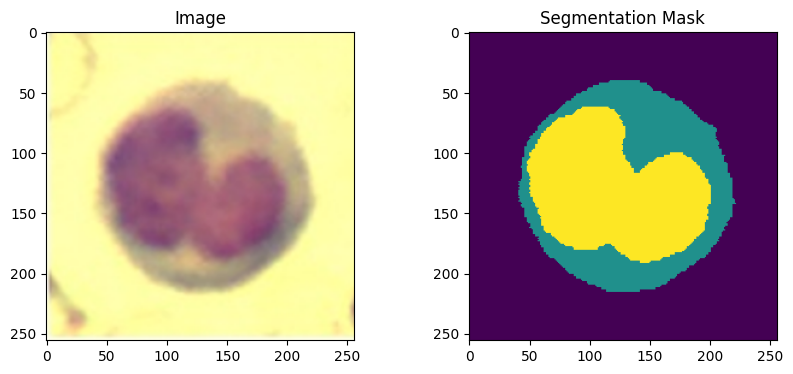

{'0': 'background', '1': 'cytoplasm', '2': 'nucleus'}

In [3]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(train_dataset[0][0])
plt.title('Image')

plt.subplot(1, 2, 2)
plt.imshow(train_dataset[0][1])
plt.title('Segmentation Mask')

plt.show()

info['pixel_labels']

## 2. Data Splitting

Data splitting ensures that a machine learning model generalizes well on unseen data.
The dataset is divided into training, validation, and test sets.
Think of the training set as the material you use to prepare for an exam, the validation set as the practice tests to fine-tune your preparation, and the test set as the actual exam where your knowledge is assessed.

When doing data splitting, always fix your random states, it makes your work reproducible.
Also, when you execute the notebook multiple times, you always want the same image to be in the same set.

In [4]:
from sklearn.model_selection import train_test_split

# Stratified split
train_data, test_data, train_labels, test_labels = train_test_split(
    all_images,
    all_labels,
    test_size=0.2,
    random_state=42,
)

print(f"Training data size: {len(train_data)}")
print(f"Test data size: {len(test_data)}")

Training data size: 288
Test data size: 72


### Stratified Splitting

Stratified splitting ensures that class proportions are maintained across splits, which is crucial for imbalanced datasets.
Here's how you would implement it.
However, this will be used purely illustratively since we're working with a segmentation task.

In [5]:
# define our random labels, this could indicate the collection centers,
# or any other sample-level information
rand_labels = np.random.randint(0, 2, size=len(all_images))

# Stratified split
dummy_train_data, dummy_test_data, dummy_train_labels, dummy_test_labels = train_test_split(
    all_images,
    all_labels,
    test_size=0.2,
    stratify=rand_labels,
    random_state=42,
)

print(f"Training data size: {len(dummy_train_data)}")
print(f"Test data size: {len(dummy_test_data)}")

Training data size: 288
Test data size: 72


### Cross-Validation

Cross-validation divides data into k subsets, iteratively training on k-1 and validating on the remaining subset.
This ensures the model is evaluated robustly across the dataset.
In the lecture we used 10-fold cross-validation, thus k=10. Here we take k=5.
Observe again that we fix the random seed for reproducibility.

In [6]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold_index, (train_index, val_index) in enumerate(kf.split(train_dataset)):
    train_data, val_data = train_dataset.imgs[train_index], train_dataset.imgs[val_index]
    train_labels, val_labels = train_dataset.labels[train_index], train_dataset.labels[val_index]

    print(f"Fold: {fold_index}")
    print(f"Training data size: {len(train_data)}")
    print(f"Test data size: {len(val_data)}\n")

    # Train and evaluate your model
    # ...

Fold: 0
Training data size: 224
Test data size: 56

Fold: 1
Training data size: 224
Test data size: 56

Fold: 2
Training data size: 224
Test data size: 56

Fold: 3
Training data size: 224
Test data size: 56

Fold: 4
Training data size: 224
Test data size: 56



## 3. Image Segmentation with SAM
The Segment Anything Model (SAM) is designed to segment objects in images with minimal input. You will use it to generate masks for medical images.

### Use the SAM Model

In [7]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2


def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
    )

Let's use the first image of the test set as an example image to see SAM in action.

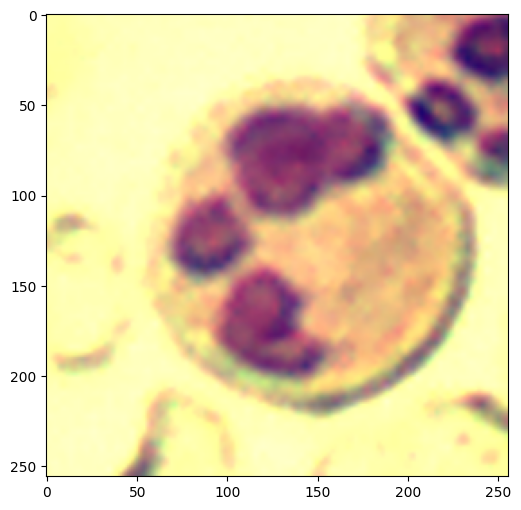

In [8]:
image = np.asarray(test_dataset[0][0])

plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis("on")
plt.show()

### Selecting objects with SAM

First, load the SAM model and predictor.
Change the path below to point to the SAM checkpoint.
Running on CUDA and using the default model are recommended for best results.

In [9]:
import os

if not os.path.exists("sam_vit_h_4b8939.pth"):
    !pip install wget
    import wget
    wget.download('https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth')
    # If code does not work, try the following:
    #!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=ff030480cfc0dcdeba4b76f18c3c31bf0bf87496ca65bf8ab341cc55abca21d1
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [10]:
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cpu"  # change to 'cuda' if available

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

Process the image to produce an image embedding (latent vector or feature vector, which are outputs from the network or intermediate values within the network) by calling `SamPredictor.set_image`.
`SamPredictor` remembers this embedding and will use it for subsequent mask prediction.

In [11]:
predictor.set_image(image)

To select the nucleus of the cell of the stained white blood cell, choose a point on it.
Points are input to the model in (x,y) format and come with labels 1 (foreground point) or 0 (background point).
Multiple points can be input; here we use only one.
The chosen point will be shown as a star on the image.

In [12]:
input_point = np.array([[256//2, 256//2]])
input_label = np.array([1])

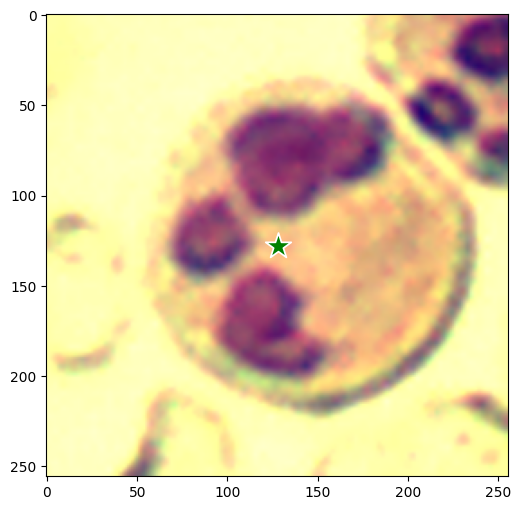

In [13]:
plt.figure(figsize=(6, 6))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis("on")
plt.show()

Predict with `SamPredictor.predict`. The model returns masks, quality predictions for those masks, and low resolution mask logits that can be passed to the next iteration of prediction.

In [14]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

With `multimask_output=True` (the default setting), SAM outputs 3 masks, where `scores` gives the model's own estimation of the quality of these masks. This setting is intended for ambiguous input prompts, and helps the model disambiguate different objects consistent with the prompt. When `False`, it will return a single mask. For ambiguous prompts such as a single point, it is recommended to use `multimask_output=True` even if only a single mask is desired; the best single mask can be chosen by picking the one with the highest score returned in `scores`. This will often result in a better mask.

In [15]:
masks.shape  # (number_of_masks) x H x W

(3, 256, 256)

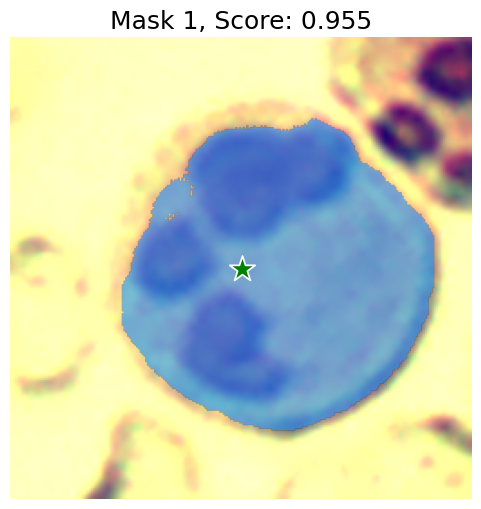

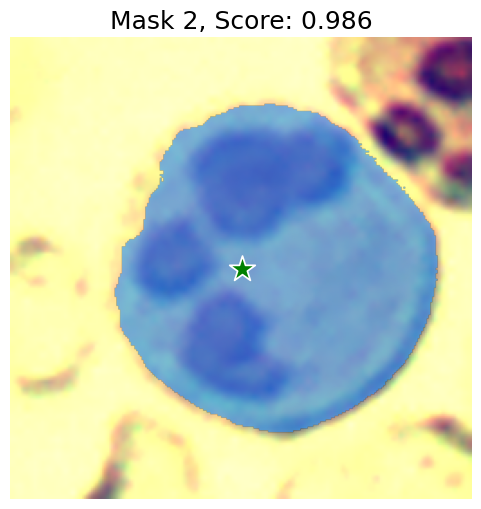

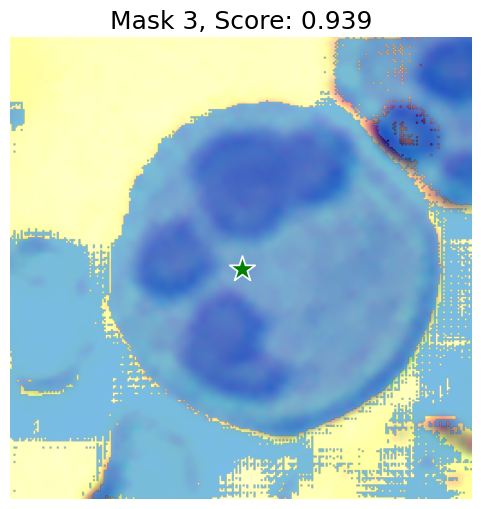

In [16]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis("off")
    plt.show()

### Specifying a specific object with additional points

The single input point is ambiguous, and the model has returned multiple objects consistent with it. To obtain a single object, multiple points can be provided. If available, a mask from a previous iteration can also be supplied to the model to aid in prediction. When specifying a single object with multiple prompts, a single mask can be requested by setting `multimask_output=False`.

In [17]:
input_point = np.array([[256//2, 256//2], [256//2+10, 256//2 + 10]])
input_label = np.array([1, 1])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [18]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

In [19]:
masks.shape

(1, 256, 256)

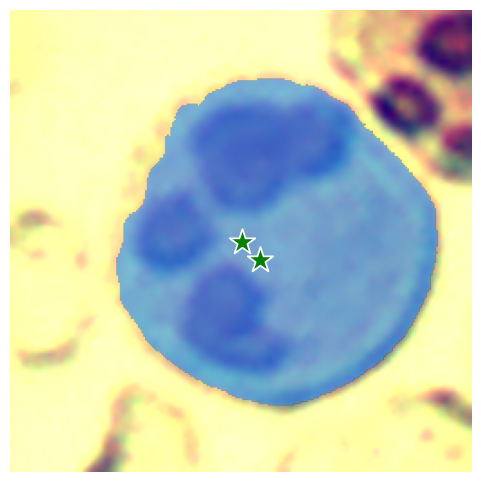

In [20]:
plt.figure(figsize=(6, 6))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis("off")
plt.show()

To exclude the rest of the cell body (i.e., the cytoplasm) and specify just the nucleus of the cell, a background point (with label 0, here shown in red) can be supplied.

In [21]:
input_point = np.array([[80, 120], [160, 120]])
input_label = np.array([1, 0])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [22]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

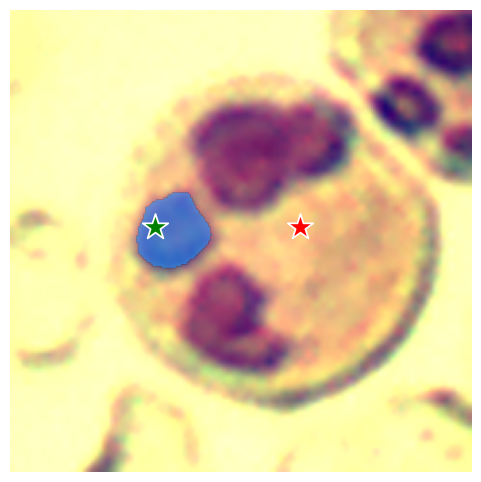

In [23]:
plt.figure(figsize=(6, 6))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis("off")
plt.show()

### Specifying an object with a box

The model can also take a box as input, provided in x1y1x2y2 format.

In [24]:
input_box = np.array([50, 30, 230, 230])

In [25]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

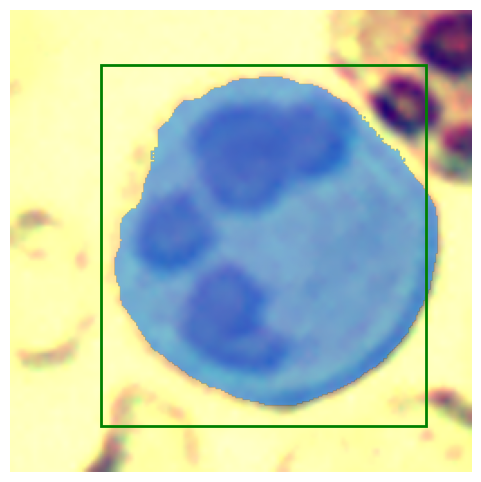

In [26]:
plt.figure(figsize=(6, 6))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis("off")
plt.show()

## 4. Evaluating Image Segmentation with SAM
Now, we will use the training set of our dataset to choose the mask that can segment the cells nicely. Here, we have the assumption that they are usually located in the middle of the image.f

In [27]:
len(train_dataset), len(test_dataset)

(280, 80)

In [28]:
# define the middle point of the image
input_point = np.array([[256//2, 256//2]])
input_label = np.array([1])

Let's look at whether our hypotheses about the middle alignment make sense.

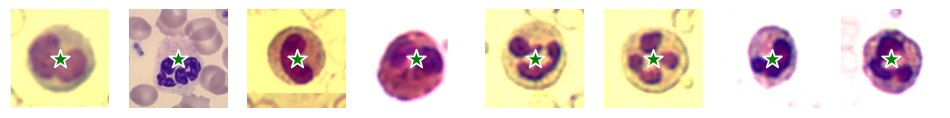

In [29]:
fig, axes = plt.subplots(1, 8, figsize=(12, 6))
for i, ax in enumerate(axes):
    ax.imshow(train_dataset[i][0])
    show_points(input_point, input_label, ax, marker_size=200)
    ax.axis("off")
fig.show()

Our hypothesis looks good, but let's evaluate it on the test set.
Since this takes a bit of time, we will limit ourselves to only doing it for the first 10 images, but you can run it for the full dataset if you have time!

In [30]:
true_masks = []
pred_masks = []
for i, data in tqdm(enumerate(test_dataset)):
    # limit to the first 10 images
    if i > 9:
        break

    image, true_mask = data

    image = np.asarray(test_dataset[0][0])
    predictor.set_image(image)

    pred_mask, _, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        mask_input=mask_input[None, :, :],
        multimask_output=False,
    )

    # we will only consider the task of segmenting the background from the cell,
    # and thus discard the information if it's cytoplasm or a nucleus
    true_mask[true_mask == 2] = 1
    true_masks.append(true_mask)
    pred_masks.append(pred_mask)

true_masks = np.stack(true_masks, axis=0)
pred_masks = np.concatenate(pred_masks, axis=0)

10it [24:04, 144.42s/it]


In [37]:
import numpy as np

def compute_dice(pred, true):
    """
    Compute Dice coefficient for binary masks.
    Args:
        pred (np.ndarray): predicted binary mask (H, W)
        true (np.ndarray): ground truth binary mask (H, W)
    Returns:
        dice_score (float)
    """
    pred = pred.astype(bool)
    true = true.astype(bool)
    intersection = np.logical_and(pred, true).sum()
    return (2. * intersection + 1e-6) / (pred.sum() + true.sum() + 1e-6)

# Compute Dice for each image pair
dice_scores = [compute_dice(p, t) for p, t in zip(pred_masks, true_masks)]

# Print average Dice score
print(f"Average Dice Score: {np.mean(dice_scores):.2f}")


Average Dice Score: 0.79


A dice score of $>0.85$ is quite good when we consider that we just selected the middle key point.